In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
dataset = datasets.MNIST(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)

VAL_RATIO = 0.2
n_val = int(len(dataset) * VAL_RATIO)
n_train = len(dataset) - n_val
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])

transform = transforms.Normalize((0.1307,), (0.3081,))

train_set = PreloadedDataset.from_dataset(train_set, transform, device)
val_set = PreloadedDataset.from_dataset(val_set, transform, device)
test_set = PreloadedDataset.from_dataset(t_dataset, transform, device)

In [4]:
def train(
        model,
        train_set,
        val_set,
        optimizer,
        criterion,
        n_epochs,
        batch_size,
):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        model.train()
        train_loss = 0
        for _, (x, _) in loop:
            if epoch > 0:
                loop.set_description(f'Epoch [{epoch}/{n_epochs}]')
                loop.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1])

            optimizer.zero_grad()
            x_hat = model(x)
            loss = criterion(x_hat, x)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        with torch.no_grad():
            model.eval()
            val_loss = 0
            for x, _ in val_loader:
                x_hat = model(x)
                loss = criterion(x_hat, x)
                val_loss += loss.item()
            val_losses.append(val_loss / len(val_loader))
        
    return train_losses, val_losses

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 5),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 5),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(12800, 4),
            nn.Softmax(dim=1),
        )

        self.decoder = nn.Sequential(
            nn.Linear(4, 400),
            nn.ReLU(True),
            nn.Linear(400, 12800),
            nn.ReLU(True),
            nn.Unflatten(1, (32, 20, 20)),
            nn.ConvTranspose2d(32, 16, kernel_size=5),
            nn.ConvTranspose2d(16, 1, kernel_size=5),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = AutoEncoder().to(device)

In [6]:
LR = 1e-3
WD = 1e-5
EPOCHS = 30 
BATCH_SIZE = 128

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)

train_losses, val_losses = train(model, train_set, val_set, optimizer, criterion, EPOCHS, BATCH_SIZE)

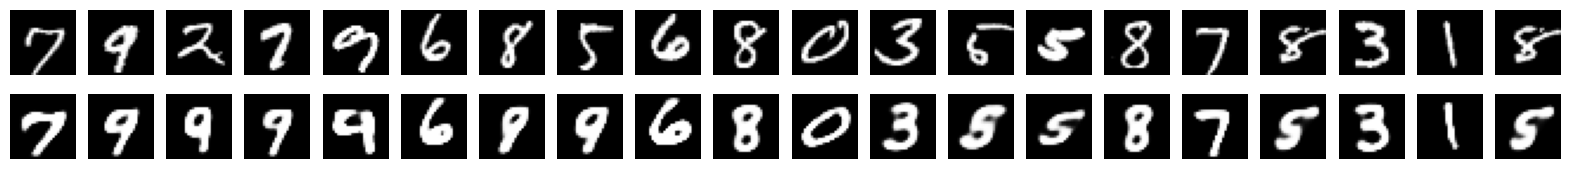

In [10]:
sample_size = 20
idxs = torch.randint(0, len(test_set), (sample_size,))

fig, axes = plt.subplots(2, sample_size, figsize=(sample_size, 2))
for i, idx in enumerate(idxs):
    x, _ = test_set[idx]
    x_hat = model(x.unsqueeze(0))
    axes[0, i].imshow(x.squeeze().cpu(), cmap='gray')
    axes[1, i].imshow(x_hat.squeeze().cpu().detach(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].axis('off')
plt.show()